# Buddy-Buddy classifier

# 0. 초기세팅, 모듈 설치

In [35]:
import warnings

warnings.filterwarnings(action='ignore')

In [ ]:
pip install pandas

In [ ]:
pip install geopy

In [ ]:
pip install numpy

In [ ]:
pip install folium

In [ ]:
pip install scikit-learn

In [ ]:
pip install matplotlib

In [ ]:
pip install openpyxl

In [ ]:
pip install pulp

# 1. 데이터 입력, 경위도 변환

### 데이터 불러오기

In [ ]:
# csv 파일 (이름, 파트, 주소)
import pandas as pd

buddySet = pd.read_csv("./OB.csv")

buddySet

### 경위도 변환 함수

### 주소, 경위도 변환 
#### - 라이브러리가 주소를 못찾을 시 해당 컬럼 직접 수정 필요함

In [38]:
import requests, json

def get_location(address):
  url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + address
  headers = {"Authorization": "KakaoAK c550c27b304a1c785fd432b138514c45"}
  api_json = json.loads(str(requests.get(url,headers=headers).text))
  address = api_json['documents'][0]['address']
  x_y = [float(address['y']), float(address['x'])]

  return x_y

In [39]:
latitudeSet = []
longtitudeSet = []
failed_address = []

locations = buddySet['주소'].astype(str)

for idx, location in enumerate(locations):
    try:
        x_y = get_location(location)
        latitudeSet.append(x_y[0])
        longtitudeSet.append(x_y[1])
    except:
        print('주솟값 변환 실패: 직접 변경 필요')
        failed_address.append(idx)
        pass

if(len(failed_address) > 0):
    print('------------------------')
    print('주소값 변환 실패 리스트')
    for failed_idx in failed_address:
        print("순번:", (failed_idx + 2), " 이름:", buddySet.loc[failed_idx, '이름'])

### 경위도 변환 결과 확인

In [ ]:
buddySet['위도'] = latitudeSet
buddySet['경도'] = longtitudeSet

buddySet

### 결측치 확인

In [41]:
import numpy as np

buddySet.isin([np.nan, np.inf]).sum()

이름    0
파트    0
주소    0
위도    0
경도    0
dtype: int64

# 2. 경위도 위치 분포 시각화

### 1. marker

In [ ]:
from folium.plugins import MarkerCluster
import folium

latitude, longitude = 37.56100278, 126.9996417
s_korea = folium.Map(location = [latitude, longitude], zoom_start=10)

marker_map = MarkerCluster().add_to(s_korea)

for lat, long, name in zip(buddySet['위도'], buddySet['경도'], buddySet['이름']):
    folium.Marker([lat, long], popup = name, icon = folium.Icon(color="blue")).add_to(marker_map)
    
s_korea

### 2. heat-map

In [ ]:
import folium
from folium import plugins

latitude, longitude = 37.56100278, 126.9996417
s_korea = folium.Map(location = [latitude, longitude], zoom_start=10)

s_korea.add_child(plugins.HeatMap(zip(buddySet['위도'],
                                      buddySet['경도']), radius=8))
s_korea

# 3. Buddy Buddy 클러스터링

## 클러스터링

In [ ]:
buddySet

In [45]:
buddySet[['위도','경도']]

,위도,경도
0,37.624843,127.073821
1,37.511956,127.088283
2,37.553779,127.080537
3,37.663039,127.001890
4,37.246197,126.984144
5,37.593989,127.020418
6,37.290206,127.047406
7,37.533752,126.958787
8,37.516988,126.866501
9,37.726398,127.054271


In [46]:
clusterSet = buddySet[['위도','경도']]
clusterSet2 = clusterSet.reset_index(drop=True, inplace=True)
clusterSet2

In [47]:
#!/usr/bin/env python3.5
# coding: utf-8

import pulp
import random
import argparse

def l2_distance(point1, point2):
    return sum([(float(i)-float(j))**2 for (i,j) in zip(point1, point2)])

class subproblem(object):
    def __init__(self, centroids, data, min_size, max_size):

        self.centroids = centroids
        self.data = data
        self.min_size = min_size
        self.max_size= max_size
        self.n = len(data)
        self.k = len(centroids)

        self.create_model()

    def create_model(self):
        def distances(assignment):
            return l2_distance(self.data[assignment[0]], self.centroids[assignment[1]])

        clusters = list(range(self.k))
        assignments = [(i, j)for i in range(self.n) for j in range(self.k)]

        # outflow variables for data nodes
        self.y = pulp.LpVariable.dicts('data-to-cluster assignments',
                                  assignments,
                                  lowBound=0,
                                  upBound=1,
                                  cat=pulp.LpInteger)

        # outflow variables for cluster nodes
        self.b = pulp.LpVariable.dicts('cluster outflows',
                                  clusters,
                                  lowBound=0,
                                  upBound=self.n-self.min_size,
                                  cat=pulp.LpContinuous)

        # create the model
        self.model = pulp.LpProblem("Model for assignment subproblem", pulp.LpMinimize)

        # objective function
        self.model += pulp.lpSum([distances(assignment) * self.y[assignment] for assignment in assignments])

        # flow balance constraints for data nodes
        for i in range(self.n):
            self.model += pulp.lpSum(self.y[(i, j)] for j in range(self.k)) == 1

        # flow balance constraints for cluster nodes
        for j in range(self.k):
            self.model += pulp.lpSum(self.y[(i, j)] for i in range(self.n)) - self.min_size == self.b[j]
            
        # capacity constraint on outflow of cluster nodes
        for j in range(self.k):
            self.model += self.b[j] <= self.max_size - self.min_size 

        # flow balance constraint for the sink node
        self.model += pulp.lpSum(self.b[j] for j in range(self.k)) == self.n - (self.k * self.min_size)


    def solve(self):
        self.status = self.model.solve()

        clusters = None
        if self.status == 1:
            clusters= [-1 for i in range(self.n)]
            for i in range(self.n):
                for j in range(self.k):
                    if self.y[(i, j)].value() > 0:
                        clusters[i] = j
        return clusters

def initialize_centers(dataset, k):
    ids = list(range(len(dataset)))
    random.shuffle(ids)
    return [dataset[id] for id in ids[:k]]

def compute_centers(clusters, dataset):
    # canonical labeling of clusters
    ids = list(set(clusters))
    c_to_id = dict()
    for j, c in enumerate(ids):
        c_to_id[c] = j
    for j, c in enumerate(clusters):
        clusters[j] = c_to_id[c]

    k = len(ids)
    dim = len(dataset[0])
    centers = [[0.0] * dim for i in range(k)]
    counts = [0] * k
    for j, c in enumerate(clusters):
        for i in range(dim):
            centers[c][i] += dataset[j][i]
        counts[c] += 1
    for j in range(k):
        for i in range(dim):
            centers[j][i] = centers[j][i]/float(counts[j])
    return clusters, centers

def minsize_kmeans(dataset, k, min_size=0, max_size=None):
    n = len(dataset)
    if max_size == None:
        max_size = n

    centers = initialize_centers(dataset, k)
    clusters = [-1] * n

    converged = False
    while not converged:
        m = subproblem(centers, dataset, min_size, max_size)
        clusters_ = m.solve()
        if not clusters_:
            return None, None
        clusters_, centers = compute_centers(clusters_, dataset)

        converged = True
        i = 0
        while converged and i < len(dataset):
            if clusters[i] != clusters_[i]:
                converged = False
            i += 1
        clusters = clusters_

    return clusters, centers

def cluster_quality(cluster):
    if len(cluster) == 0:
        return 0.0

    quality = 0.0
    for i in range(len(cluster)):
        for j in range(i, len(cluster)):
            quality += l2_distance(cluster[i], cluster[j])
    return quality / len(cluster)

def compute_quality(data, cluster_indices):
    clusters = dict()
    for i, c in enumerate(cluster_indices):
        if c in clusters:
            clusters[c].append(data[i])
        else:
            clusters[c] = [data[i]]
    return sum(cluster_quality(c) for c in clusters.values())


In [48]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = buddySet[['위도', '경도']]

from sklearn.preprocessing import StandardScaler

X_features_scaled = StandardScaler().fit_transform(X_features)

In [49]:
X_features_scaled

array([[ 8.78640430e-01,  6.53497735e-01],
       [ 1.18297403e-01,  7.78620863e-01],
       [ 3.99992971e-01,  7.11602020e-01],
       [ 1.13590773e+00,  3.11391500e-02],
       [-1.67171425e+00, -1.22405757e-01],
       [ 6.70826147e-01,  1.91442251e-01],
       [-1.37529187e+00,  4.24948063e-01],
       [ 2.65100419e-01, -3.41797895e-01],
       [ 1.52190233e-01, -1.14027082e+00],
       [ 1.56265679e+00,  4.84343838e-01],
       [-1.44143787e+00,  1.00737953e+00],
       [ 1.64118527e+00,  3.08083547e-01],
       [-4.85335618e+00,  4.80640462e-01],
       [ 4.04734670e-01, -3.66746362e-01],
       [-2.45430837e-02, -1.12781338e+00],
       [ 3.18804620e-01,  3.89863389e-01],
       [ 6.58271653e-02, -7.28701208e-01],
       [-7.98461333e-02, -3.99092703e-01],
       [-7.51945861e-01,  1.04292033e+00],
       [-6.50078439e-02,  1.03805535e+00],
       [-7.51945861e-01,  1.04292033e+00],
       [ 4.34352241e-01, -1.30100334e+00],
       [-4.70156544e-02, -6.15755912e-01],
       [ 3.

In [56]:
#data set    
data = X_features_scaled

#number of clusters    
k = 32

#min size
min_size = 1

#max size
max_size = 2

#run the algorithm for NUM_ITER times and return the best clustering
NUM_ITER = 6

best = None
best_clusters = None
for i in range(NUM_ITER):
    clusters, centers = minsize_kmeans(data, k, min_size, max_size)
    if clusters:
        quality = compute_quality(data, clusters)
    if not best or (quality < best):
        best = quality
        best_clusters = clusters

groupSet = pd.DataFrame(columns=['조'])

if best:
    print('cluster assignments:')
    for i in range(len(best_clusters)):
        print(best_clusters[i])
        groupSet = groupSet.append({'조': best_clusters[i]}, ignore_index=True)
    print('sum of squared distances: %.4f'%(best))
else:
    print('no clustering found')




Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/d7b6c3a550544415adc7adb64639928f-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/d7b6c3a550544415adc7adb64639928f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 127 COLUMNS
At line 9296 RHS
At line 9419 BOUNDS
At line 11276 ENDATA
Problem MODEL has 122 rows, 1856 columns and 3744 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 5.06935 - 0.00 seconds
Cgl0005I 57 SOS with 1824 members
Cgl0004I processed model has 90 rows, 1856 columns (1856 integer (1856 of which binary)) and 3712 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 5.06935
Cbc0038I Before mini branch and

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/4bd1e6be788649048daba0b3ee40026e-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/4bd1e6be788649048daba0b3ee40026e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 127 COLUMNS
At line 9318 RHS
At line 9441 BOUNDS
At line 11298 ENDATA
Problem MODEL has 122 rows, 1856 columns and 3744 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.65716 - 0.00 seconds
Cgl0005I 57 SOS with 1824 members
Cgl0004I processed model has 90 rows, 1856 columns (1856 integer (1856 of which binary)) and 3712 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.65716
Cbc0038I Before mini branch and

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/bdb263c8a9134e5aad99764a27b8ea62-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/bdb263c8a9134e5aad99764a27b8ea62-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 127 COLUMNS
At line 9321 RHS
At line 9444 BOUNDS
At line 11301 ENDATA
Problem MODEL has 122 rows, 1856 columns and 3744 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.52247 - 0.00 seconds
Cgl0005I 57 SOS with 1824 members
Cgl0004I processed model has 90 rows, 1856 columns (1856 integer (1856 of which binary)) and 3712 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.52247
Cbc0038I Before mini branch and

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/c1d4d231edad4d3aa4d1bed934433040-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/c1d4d231edad4d3aa4d1bed934433040-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 127 COLUMNS
At line 9320 RHS
At line 9443 BOUNDS
At line 11300 ENDATA
Problem MODEL has 122 rows, 1856 columns and 3744 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2.65326 - 0.00 seconds
Cgl0005I 57 SOS with 1824 members
Cgl0004I processed model has 90 rows, 1856 columns (1856 integer (1856 of which binary)) and 3712 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 2.65326
Cbc0038I Before mini branch and

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/9a9802cdbf6841c1bef6990de7ba08fd-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/9a9802cdbf6841c1bef6990de7ba08fd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 127 COLUMNS
At line 9330 RHS
At line 9453 BOUNDS
At line 11310 ENDATA
Problem MODEL has 122 rows, 1856 columns and 3744 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2.15095 - 0.00 seconds
Cgl0005I 57 SOS with 1824 members
Cgl0004I processed model has 90 rows, 1856 columns (1856 integer (1856 of which binary)) and 3712 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 2.15095
Cbc0038I Before mini branch and

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/38a97d97e25c402b82b5bf4a113de2e1-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/38a97d97e25c402b82b5bf4a113de2e1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 127 COLUMNS
At line 9324 RHS
At line 9447 BOUNDS
At line 11304 ENDATA
Problem MODEL has 122 rows, 1856 columns and 3744 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 6.02641 - 0.00 seconds
Cgl0005I 57 SOS with 1824 members
Cgl0004I processed model has 90 rows, 1856 columns (1856 integer (1856 of which binary)) and 3712 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 6.02641
Cbc0038I Before mini branch and

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/62f93af5f50145caa6dcbf193c8284d9-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/62f93af5f50145caa6dcbf193c8284d9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 127 COLUMNS
At line 9322 RHS
At line 9445 BOUNDS
At line 11302 ENDATA
Problem MODEL has 122 rows, 1856 columns and 3744 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2.12555 - 0.00 seconds
Cgl0005I 57 SOS with 1824 members
Cgl0004I processed model has 90 rows, 1856 columns (1856 integer (1856 of which binary)) and 3712 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 2.12555
Cbc0038I Before mini branch and

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/9a432d97554b407b91a6d28cba4dde0b-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/78/nskjw12s4tjd5g43cgbrwt9h0000gn/T/9a432d97554b407b91a6d28cba4dde0b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 127 COLUMNS
At line 9320 RHS
At line 9443 BOUNDS
At line 11300 ENDATA
Problem MODEL has 122 rows, 1856 columns and 3744 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.03159 - 0.00 seconds
Cgl0005I 57 SOS with 1824 members
Cgl0004I processed model has 90 rows, 1856 columns (1856 integer (1856 of which binary)) and 3712 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 1.03159
Cbc0038I Before mini branch and

In [57]:
groupSet

,조
0,24
1,6
2,13
3,23
4,11
5,2
6,12
7,3
8,8
9,27


## n 클러스터 시각화

In [58]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

cm.jet(1/4)

def clusterScatter(n_cluster, X_features): 
    c_colors = []
    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    Y_labels = kmeans.fit_predict(X_features)

    for i in range(n_cluster):
        c_color = cm.jet(float(i) / n_cluster) 
        c_colors.append(c_color)
        plt.scatter(X_features[Y_labels == i,0], X_features[Y_labels == i,1],
                     marker='o', color=c_color, edgecolor='black', s=50, 
                     label='cluster '+ str(i))       

    for i in range(n_cluster):
        plt.scatter(kmeans.cluster_centers_[i,0], kmeans.cluster_centers_[i,1], 
                    marker='^', color=c_colors[i], edgecolor='w', s=200)
        
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

## k 값은 지역구 분류 기준의 개수 

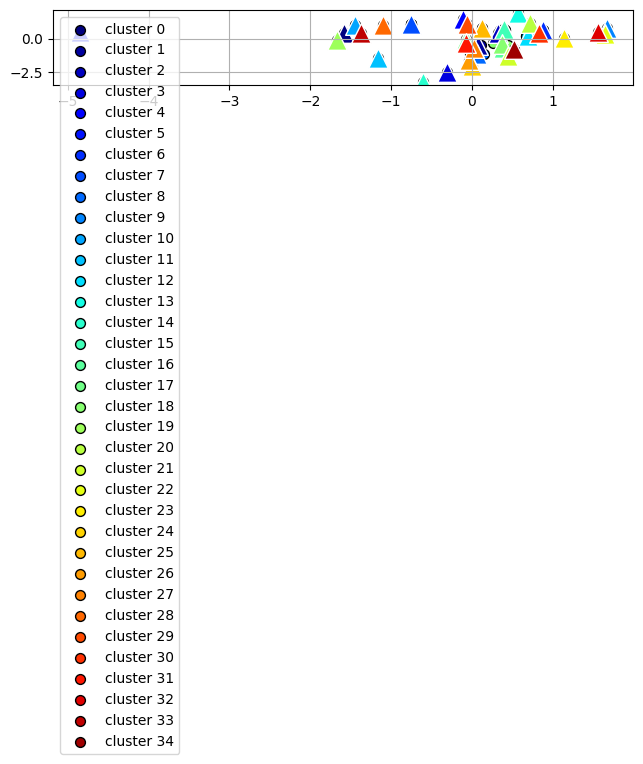

In [59]:
clusterScatter(35, X_features_scaled) 

## 성능 평가

In [60]:
from matplotlib import cm

def silhouetteViz(n_cluster, X_features): 
    
    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    Y_labels = kmeans.fit_predict(X_features)
    
    silhouette_values = silhouette_samples(X_features, Y_labels, metric='euclidean')

    y_ax_lower, y_ax_upper = 0, 0
    y_ticks = []

    for c in range(n_cluster):
        c_silhouettes = silhouette_values[Y_labels == c]
        c_silhouettes.sort()
        y_ax_upper += len(c_silhouettes)
        color = cm.jet(float(c) / n_cluster)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouettes,
                 height=1.0, edgecolor='none', color=color)
        y_ticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouettes)
    
    silhouette_avg = np.mean(silhouette_values)
    plt.axvline(silhouette_avg, color='red', linestyle='--')
    plt.title('Number of Cluster : '+ str(n_cluster)+'\n' \
              + 'Silhouette Score : '+ str(round(silhouette_avg,3)))
    plt.yticks(y_ticks, range(n_cluster))   
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.tight_layout()
    plt.show()

### silhouette Score를 확인한다

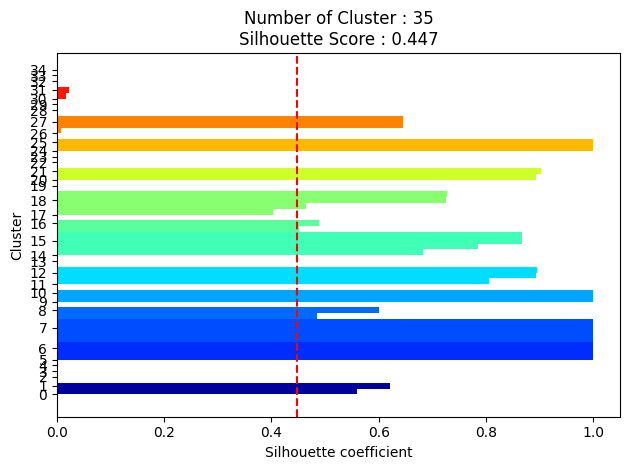

In [61]:
silhouetteViz(35, X_features_scaled)

## 클러스터링 진행

In [ ]:
buddySet['조'] = groupSet
buddySet

## 분류 시각화

In [63]:
import numpy as np

colors = np.random.randint(0, 255, size=(40, 3))

color = ['#{:02X}{:02X}{:02X}'.format(*c) for c in colors]

colorSet = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray', 'white', 'red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray', 'white']


In [ ]:
from folium import Map, Marker, Icon

latitude, longitude = 37.56100278, 126.9996417
s_korea = folium.Map(location = [latitude, longitude], zoom_start=11)

for i in range(len(buddySet)):
    groupLabel = buddySet['조'][i]
    name = buddySet['이름'][i]
    part = buddySet['파트'][i]
    oldYoung = 'OB'
    identify = "(" + oldYoung + ")" + part + ": " + name
    
    icon = folium.Icon(color=colorSet[groupLabel], icon_color=color[groupLabel], icon_size=(35, 40))
    
    folium.Marker(location = (buddySet['위도'][i],buddySet['경도'][i]), popup = folium.Popup(identify, max_width=200), icon= icon).add_to(s_korea)

s_korea

## 대분류 결과 (n 분류의 개수)

In [ ]:
import math

n = 35
num = 1;
count = 0;

result = pd.DataFrame(columns=['이름', '파트', '주소','조'])

for i in range(n):
    clusterSet = buddySet[buddySet['조']==i]
    clusterLen = len(clusterSet)
    
    print("=============================================")
    print(num,"조")
    print(clusterSet[['이름', '파트', '주소']])
    result = result.append(clusterSet[['이름', '파트', '주소']], ignore_index=True)
    result['조'][count:count+clusterLen] = num
    num = num + 1    
    count = count + clusterLen
        
    

In [ ]:
result

In [67]:
result.to_excel('result_OB.xlsx', index=False)